<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#check-agent-limit-order" data-toc-modified-id="check-agent-limit-order-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>check agent limit order</a></span></li><li><span><a href="#meta-algorithm" data-toc-modified-id="meta-algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>meta algorithm</a></span><ul class="toc-item"><li><span><a href="#MMMW" data-toc-modified-id="MMMW-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>MMMW</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [233]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style(style='white') 

from tqdm.auto import tqdm

In [3]:
from dotenv import load_dotenv
import os
import finnhub

In [4]:
load_dotenv()  # take environment variables from .env.

True

## load data

In [5]:
API_KEY = os.getenv("API_KEY")
# print(f"using {API_KEY=} for api")

In [6]:
# Setup client
finnhub_client = finnhub.Client(api_key=API_KEY)

In [7]:
from_date = pd.to_datetime("2021-11-01")
to_date = pd.to_datetime("2021-11-05")
symbol = 'AAPL'

In [8]:
print(f"loading date {from_date=} {to_date=}")

loading date from_date=Timestamp('2021-11-01 00:00:00') to_date=Timestamp('2021-11-05 00:00:00')


In [9]:
symbols = ['AAPL', 'MSFT', 'HPQ', 'WMT']

In [10]:
results = []
for symbol in symbols:
    res = finnhub_client.stock_candles(
        symbol, 1, int(from_date.timestamp()), int(to_date.timestamp())
    )
    res['symbol'] = symbol
    results.append(res)

In [11]:
df = pd.DataFrame()
for res in results:
    df = pd.concat([df, pd.DataFrame(res)])

In [12]:
df['timestamp'] = pd.to_datetime(df['t'], unit='s')

In [13]:
df.head()

,c,h,l,o,s,t,v,symbol,timestamp
0,150.15,150.15,149.95,149.95,ok,1635753600,2289,AAPL,2021-11-01 08:00:00
1,150.00,150.00,150.00,150.00,ok,1635753660,747,AAPL,2021-11-01 08:01:00
2,149.97,150.00,149.97,149.98,ok,1635753720,900,AAPL,2021-11-01 08:02:00
3,150.00,150.03,150.00,150.00,ok,1635753780,2771,AAPL,2021-11-01 08:03:00
4,149.95,150.00,149.95,150.00,ok,1635753840,1961,AAPL,2021-11-01 08:04:00


In [14]:
df.to_csv('stocks.csv', index=False)

In [24]:
?pd.read_csv

In [28]:
df = pd.read_csv('stocks.csv')
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

In [31]:
symbol = 'AAPL'

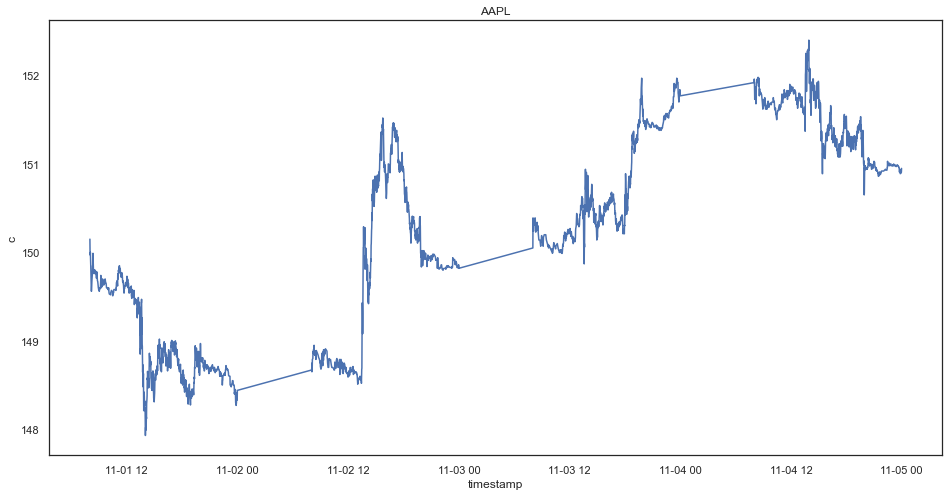

In [234]:
fig, axs = plt.subplots(figsize=(16, 8))
plt.title(symbol)
sns.lineplot(x='timestamp', y='c', data=df[df.symbol == symbol]);

## check agent limit order

In [166]:
from Agent import Agent

In [167]:
p_1 = 1

In [168]:
a = Agent(b=0.5, alpha=10, a_1=p_1)

In [169]:
a.limit_order(p_current=1.5, p_next=4)

In [170]:
a.inventory

-260

In [171]:
a.cash

715.0

## meta algorithm

MMMW, MMFPL, simple Follow-The-Leader2 (FTL), and simple uniform averaging over all strategies

In [172]:
Beta = np.array([1, 2, 3, 4, 5, 10, 20, 40, 80, 100]) / 100 # in dollars, not in cents
N = len(Beta)
B = np.max(Beta)
ALPHA = 1

In [300]:
Beta

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.1 , 0.2 , 0.4 , 0.8 , 1.  ])

In [173]:
agent_to_beta = {i: b for i, b in enumerate(Beta)}
beta_to_agent = {b: i for i, b in enumerate(Beta)}

In [174]:
df['c'].diff().abs().max()

306.40000000000003

In [175]:
max_value_diff = 1  # constant for now

### MMMW

In [176]:
def update_weights(weights_prev, eta, values_prev, values_current):
    weights_new = weights_prev * np.exp(eta * (values_current - values_prev))
    weights_new = weights_new / np.sum(weights_new)  # normalization Z_t
    return weights_new

In [184]:
def get_values(agents, p):
    return np.array([a.value(p) for a in agents])
def get_inventories(agents):
    return np.array([a.inventory for a in agents])
def get_cash(agents):
    return np.array([a.cash for a in agents])

In [178]:
def eta(t):
    return np.sqrt(np.log(N) / t)

In [179]:
def market_order(X, p_current):
    # X>0 => buying
    # X<0 => selling
    cash_diff = -X * p_current
    inventory_diff = X
    return cash_diff, inventory_diff

In [434]:
symbol = 'AAPL'
df_symbol = df[df.symbol == symbol]
day = df_symbol['timestamp'].dt.date.unique()[2]
df_day = df_symbol[df_symbol['timestamp'].dt.date == day]

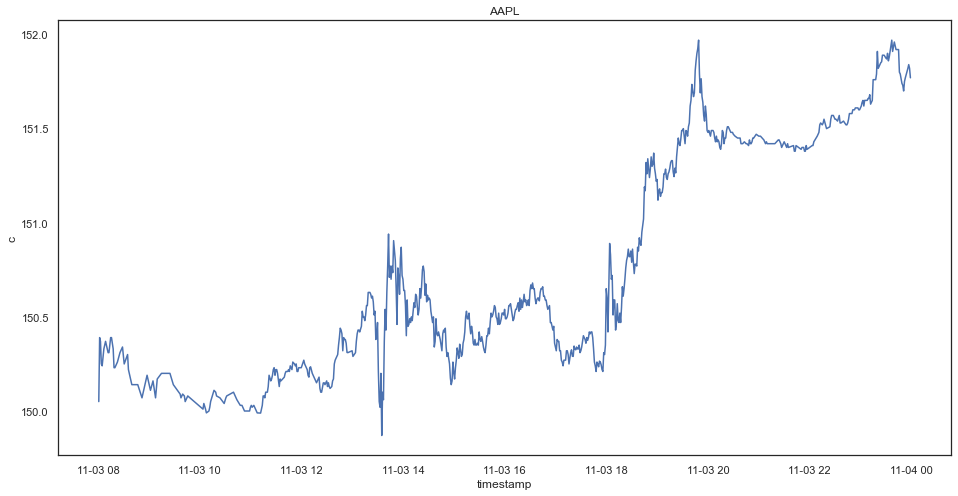

In [435]:
fig, axs = plt.subplots(figsize=(16, 8))
plt.title(symbol)
sns.lineplot(x='timestamp', y='c', data=df_day);

In [436]:
weights = np.array([1/N]*N)
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [437]:
p_1 = df_day['c'].iloc[0]

In [438]:
agents = [Agent(b=b, alpha=ALPHA, a_1=p_1) for b in Beta]

In [439]:
w = []  # weights at each step
values = []  # value at each step

G_t = 0
# cash and inventory from market orders
cash_mo_diffs = []
inventory_mo_diffs = []

for t in range(1, len(df_day)-1):
    p_current = df_day.iloc[t]['c']
    p_next = df_day.iloc[t+1]['c']

    # sending limit orders
    current_values = get_values(agents, p_current)
    current_inventories = get_inventories(agents)
    for a in agents:
        a.limit_order(p_current, p_next)
    next_values = get_values(agents, p_next)
    next_inventories = get_inventories(agents)
    
    eta_current = eta(t)
    diffs = current_values.reshape(1, -1) - current_values.reshape(-1, 1)  
    diffs = np.abs(diffs)
    G_t = max(np.max(diffs), G_t)
    
    eta_current = min(eta_current, G_t)
    
    w.append(weights)
    values.append(current_values)
    
    weights_old = weights
    weights = update_weights(weights, eta_current, current_values, next_values)
    
    # send market order
    X = np.sum(current_inventories * (weights - weights_old))
    cash_diff, inventory_diff = market_order(X, p_next)
    cash_mo_diffs.append(cash_diff)
    inventory_mo_diffs.append(inventory_diff)
    
    
w = np.array(w)
values = np.array(values)
cash_mo_diffs = np.array(cash_mo_diffs)
inventory_mo_diffs = np.array(cash_mo_diffs)

cash_mo = np.cumsum(cash_mo_diffs)
inventory_mo = np.cumsum(inventory_mo_diffs)

In [440]:
inventory_mo.round(2)

array([-0.00000e+00,  2.00000e-01,  4.95100e+01, -3.18160e+02,
       -3.41860e+02, -3.34470e+02, -3.34470e+02, -3.59680e+02,
       -3.64830e+02, -3.64830e+02, -3.64630e+02, -3.04920e+02,
       -3.04920e+02, -3.93290e+02, -4.88520e+02, -5.05350e+02,
       -4.79670e+02, -5.44700e+02, -4.73410e+02, -2.29550e+02,
       -2.29550e+02,  2.60430e+02, -7.75360e+02, -4.00510e+02,
       -7.28160e+02, -1.58990e+02, -1.00167e+03, -1.13133e+03,
       -1.13133e+03, -1.13133e+03, -1.13133e+03, -9.30180e+02,
       -6.61400e+02, -4.92830e+02, -6.87090e+02, -5.94120e+02,
       -3.02800e+02, -6.31640e+02,  1.14280e+02, -2.07490e+02,
        1.01520e+02,  3.09610e+02,  2.07170e+02,  3.63000e+00,
       -2.81050e+02, -7.16780e+02, -6.66690e+02, -5.64280e+02,
       -5.08850e+02, -3.19860e+02, -5.38670e+02, -6.07380e+02,
       -7.23480e+02, -5.14160e+02, -3.35180e+02, -3.35180e+02,
       -1.16050e+02, -1.16050e+02, -2.86300e+02, -3.68780e+02,
       -2.88470e+02, -3.68140e+02, -4.83400e+01, -3.948

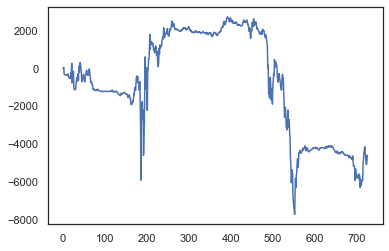

In [441]:
plt.plot(inventory_mo)

In [420]:
cash_mo + inventory_mo * df_day.iloc[2:]['c']

828         -0.000000
829         14.342726
830       6357.564664
831       1900.927339
832      -2591.048304
            ...      
1553   -616644.376083
1554   -616644.376083
1555   -616312.178180
1556   -616755.296114
1557   -616312.443249
Name: c, Length: 730, dtype: float64

In [400]:
# not needed
tmp = pd.DataFrame(w).add_prefix('agent_')
tmp['T'] = tmp.index
tmp = pd.wide_to_long(tmp, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'weight'})
tmp['agent'] = tmp['agent'].astype(str)

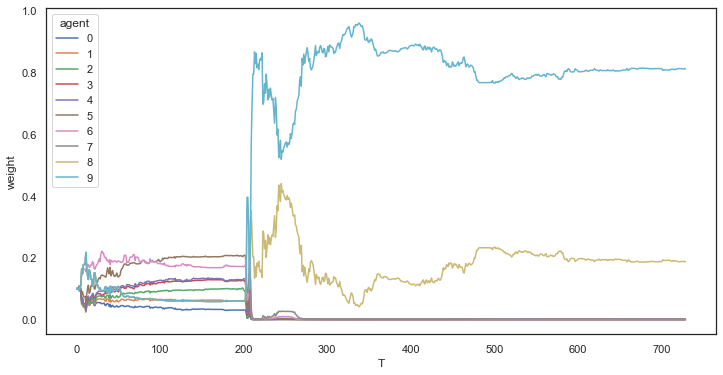

In [401]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='weight', hue='agent', data=tmp);

In [404]:
value_df = pd.DataFrame((w * values).sum(axis=1), columns=['value'])
value_df['T'] = value_df.index
value_df['value'] += cash_mo

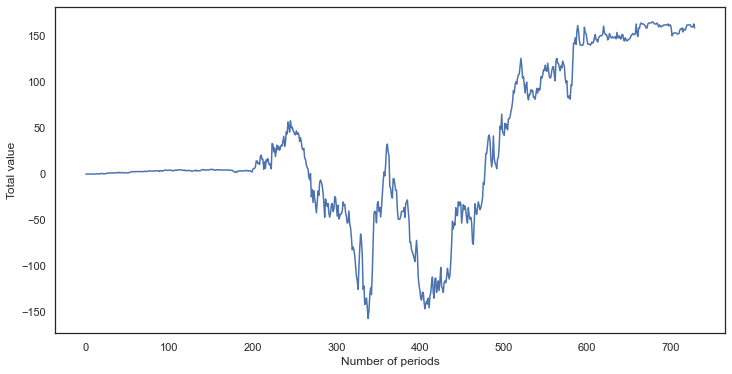

In [405]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='value', data=value_df, ax=axs);
plt.xlabel('Number of periods')
plt.ylabel('Total value');
# plt.grid(None);

In [406]:
value_df = pd.DataFrame(values).add_prefix('agent_')
value_df['T'] = value_df.index
value_df = pd.wide_to_long(value_df, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'value'})
# value_df['agent'] = value_df['agent'].astype(str)
value_df['agent'] = (100 * value_df['agent'].map(agent_to_beta)).astype(int).astype(str)

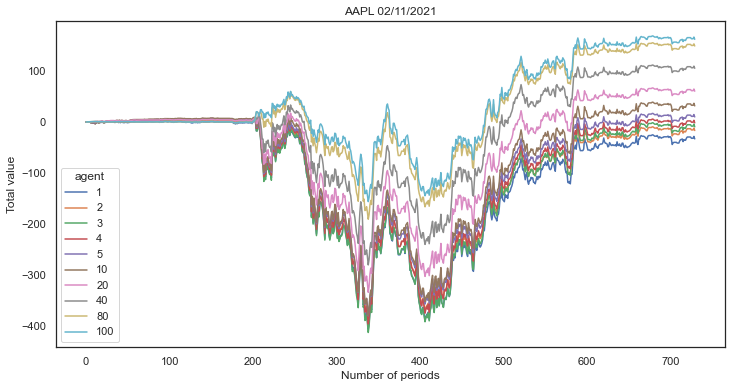

In [407]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='value', hue='agent', data=value_df)
plt.title(f'{symbol} {pd.to_datetime(day).strftime("%d/%m/%Y")}')

plt.xlabel('Number of periods')
plt.ylabel('Total value');